# Assignment 1 : MLP Classification (Pytorch)


In [1]:
name = input("Name : ")
ID = input("student ID : ")

Name : 김윤지
student ID : 2013103


## 실습
___


## Matrix 미분 정리
$H = XW+b$</br>
$L = f(H)$</br>
$\frac{\partial L}{\partial W} = \frac{\partial H}{\partial W} \times \frac{\partial L}{\partial H} = \frac{\partial (XW+b)}{\partial W} \times\frac{\partial L}{\partial H} = X *\frac{\partial L}{\partial H}$</br>
$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial H}{\partial X} = \frac{\partial L}{\partial H} \times \frac{\partial (XW+b)}{\partial X} = \frac{\partial L}{\partial H}*W$</br>
$\frac{\partial L}{\partial b}=1*\frac{\partial L}{\partial H}$</br>

3 Layer Network를 완성하시오


In [2]:
import torch

class ThreeLayerNet(torch.nn.Module):
  def __init__(self, input_size, output_size, std=1e-4):
    super(ThreeLayerNet, self).__init__()
    torch.manual_seed(0)

    hidden1_size = 128
    hidden2_size = 64

    self.relu = torch.nn.ReLU()
    self.layer1 = torch.nn.Linear(input_size, hidden1_size)
    self.layer2 = torch.nn.Linear(hidden1_size, hidden2_size)
    self.layer3 = torch.nn.Linear(hidden2_size, output_size)

  def forward(self, X, y = None):
    feature1 = self.relu(self.layer1(X))
    feature2 = self.relu(self.layer2(feature1))
    feature3 = self.layer3(feature2)
    output = torch.nn.functional.log_softmax(feature3, dim=1)

    return output

  def accuracy(self, X, y):
      p = self.forward(X)
      pred = torch.argmax(p,dim=1)
      acc = torch.sum(pred==y).float()/X.shape[0]*100

      return acc


#### Data

In [4]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : (60000, 28, 28)
shape of y_train : (60000,)
shape of x_test : (10000, 28, 28)
shape of y_test : (10000,)


In [6]:
def preprocessing_data(x_train, x_test, y_train, y_test):
    x_train = x_train[:5000]
    y_train = y_train[:5000]
    x_test = x_test[:1000]
    y_test = y_test[:1000]

    #change dtype
    x_train = torch.from_numpy(x_train).cuda()
    x_test = torch.from_numpy(x_test).cuda()

    x_train = torch.tensor(x_train,dtype=torch.float64, device="cuda:0")
    y_train = torch.tensor(y_train,device="cuda:0")

    x_test = torch.tensor(x_test,dtype=torch.float64,device="cuda:0")
    y_test = torch.tensor(y_test,device="cuda:0")

    #reshaping
    x_train = x_train.reshape([x_train.shape[0],-1])
    x_test = x_test.reshape(x_test.shape[0],-1)


    #normalization
    mean_value = torch.mean(x_train, dim=0)
    x_train -= mean_value
    x_train = x_train/255
    x_test -= mean_value
    x_test = x_test/255


    return x_train, x_test, y_train, y_test

In [7]:
x_train, x_test, y_train, y_test = preprocessing_data(x_train, x_test, y_train, y_test)

<ipython-input-6-9c9f895cc5c5>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train,dtype=torch.float64, device="cuda:0")
<ipython-input-6-9c9f895cc5c5>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test,dtype=torch.float64,device="cuda:0")


In [8]:
print("shape of x_train :",x_train.shape)
print("shape of y_train :",y_train.shape)
print("shape of x_test :",x_test.shape)
print("shape of y_test :",y_test.shape)

shape of x_train : torch.Size([5000, 784])
shape of y_train : torch.Size([5000])
shape of x_test : torch.Size([1000, 784])
shape of y_test : torch.Size([1000])


####Training

In [9]:
N = x_train.shape[0]
input_size = x_train.shape[1]

learning_rate = 1e-03 #학습률
output_size = 10 # output target 종류의 개수
epoch_size = 30 # 학습 수

Network = ThreeLayerNet(input_size=input_size, output_size=output_size)
Network = Network.cuda()
history = {'val_acc': [],'val_loss': []}

optimizer = torch.optim.SGD(Network.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

for i in range(epoch_size+1):
    for j in range(N):

        optimizer.zero_grad()

        x_now = x_train[j].unsqueeze(0).type(torch.cuda.FloatTensor)
        y_now = y_train[j].unsqueeze(0)

        y_predict = Network(x_now)
        loss = criterion(y_predict, y_now)
        loss.backward()

        optimizer.step()

    val_acc = 0
    val_loss = 0
    for k in range(x_test.shape[0]):
        val_acc += Network.accuracy(x_test[k].unsqueeze(0).type(torch.cuda.FloatTensor), y_test[k])
        val_loss += criterion((Network.forward(x_test[k].unsqueeze(0).type(torch.cuda.FloatTensor))), y_test[k].unsqueeze(0)).detach()
    history["val_acc"].append((val_acc/x_test.shape[0]).cpu())
    history["val_loss"].append((val_loss/x_test.shape[0]).cpu())

    if i % 10 == 0:
        print(i, "train accuracy :", Network.accuracy(x_train.type(torch.cuda.FloatTensor), y_train))
        print(i, "train loss     :", loss)
        print(i, "test accuracy :", val_acc/x_test.shape[0])
        print(i, "test loss     :", val_loss/x_test.shape[0])
        print("============================================")

0 train accuracy : tensor(46.2000, device='cuda:0')
0 train loss     : tensor(2.2540, device='cuda:0', grad_fn=<NllLossBackward0>)
0 test accuracy : tensor(46.6000, device='cuda:0')
0 test loss     : tensor(2.1504, device='cuda:0')
10 train accuracy : tensor(95.5200, device='cuda:0')
10 train loss     : tensor(0.0243, device='cuda:0', grad_fn=<NllLossBackward0>)
10 test accuracy : tensor(90.3000, device='cuda:0')
10 test loss     : tensor(0.3055, device='cuda:0')
20 train accuracy : tensor(98.4600, device='cuda:0')
20 train loss     : tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
20 test accuracy : tensor(92.3000, device='cuda:0')
20 test loss     : tensor(0.2510, device='cuda:0')
30 train accuracy : tensor(99.6000, device='cuda:0')
30 train loss     : tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
30 test accuracy : tensor(92.7000, device='cuda:0')
30 test loss     : tensor(0.2424, device='cuda:0')


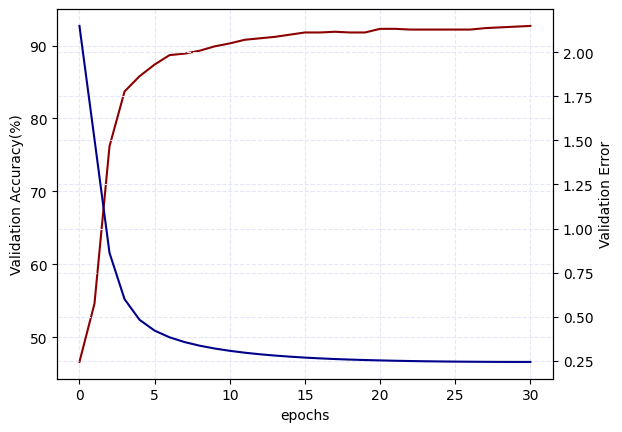

나의 최고 test accuracy :  tensor(92.7000)


In [10]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax_acc = fig.add_subplot(111)

ax_acc.plot(range(epoch_size+1), history['val_acc'], label='정확도(%)', color='darkred')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy(%)')
ax_acc.grid(linestyle='--', color='lavender')
ax_loss = ax_acc.twinx()

ax_loss.plot(range(epoch_size+1), history['val_loss'], label='오차', color='darkblue')
plt.ylabel('Validation Error')
ax_loss.yaxis.tick_right()
ax_loss.grid(linestyle='--', color='lavender')

# 그래프 표시
plt.show()

print("나의 최고 test accuracy : ",max(history['val_acc']))